In [3]:
# Libraries
import numpy as np         #Linear algebra
import pandas as pd         # EDA & Data processing
import seaborn as sns       # Statistial charts
import matplotlib.pyplot as plt     # Statistical charts                                       
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV      # Hyperparametric tuning
from scipy.stats import uniform
from sklearn.impute import KNNImputer       # Missing Imputation
from sklearn.preprocessing import StandardScaler        # Scaling    
from sklearn.linear_model import LinearRegression       # Linear Regression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor        # Random Forest, AdaBoost, Gradient Boost
from sklearn.tree import DecisionTreeRegressor      # Decision Tree
from sklearn.svm import SVR, LinearSVR      # Support Vector Machine
from sklearn.neighbors import KNeighborsRegressor       # KNN 
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score       # Evaluation Metrice (MAE, MSE, Coefficient of Determination)
import warnings     # Ignore warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
# Function for EDA
def DataExp(df):
    print(f" Viewing df: \n\n{df.head()} \n\n------------------------------")
    print(f" Rows & Columns: {df.shape} \n\n------------------------------")
    print(f"Dimension: {df.ndim} \n\n------------------------------")
    print(f"dftypes: \n\n{df.dtypes} \n\n------------------------------")
    print(f"Null Values: \n\n{df.isna().sum()} \n\n------------------------------")
    print(f"Duplicates: \n\n{df.duplicated().sum()} \n\n------------------------------")
    print(f"No Of Unique Values: \n\n{df.apply(lambda x: x.nunique())}\n\n------------------------------")
    print(f"Unique Values \n\n{df.apply(lambda x: x.unique())} \n\n-----------------------------")
    print("df Summary")
    print()
    print(df.info())
    print("------------------------------\n")
    print("Checking Outliers")
    print()
    NumericalCols = df.select_dtypes(include= "number").columns
    NumCols = len(NumericalCols)

    fig, axes = plt.subplots(nrows= NumCols//2, ncols= 4, figsize= (20, 3))
    axes = axes.flatten()

    for i, dafa in enumerate(NumericalCols):
        sns.boxplot(x= df[dafa], ax= axes[i])

    plt.tight_layout()

    plt.show()
    print("------------------------------\n")
    print(f"Categorical variables description: \n\n{df.select_dtypes(include= 'object').describe().T}")
    print("------------------------------\n")
    print(f"Continous variables description: \n\n{df.select_dtypes(include= 'number').describe().T.applymap(lambda x: format(x, '.2f'))}")    
    

In [5]:
# Function for removing noise 
def StrtoFloat(name):
    token = name.split('-')

    if len(token) == 2:
        return (float(token[0]) + float(token[1]))/2 
    
    try:
        return float(name)

    except:
        return np.nan

In [6]:
# Function for removing outliers
def OutlierTreat(column):
    if column.dtype in [float, int] :
        q1 = column.quantile(0.25)
        q3 = column.quantile(0.75)
        iqr = q3 - q1
        lc = q1 - 1.5 * iqr
        uc = q3 + 1.5 * iqr

        column = column.clip(lower= lc, upper= uc)
        return column

In [7]:
# Function to see the accuracy model wise 

def BestAlgorithm(Xtrain, Xtest, Ytrain, Ytest):
    models = {
        # "Linear Regression": (LinearRegression(), {
        #     'fit_intercept': [True, False],
        #     "normalize": [True, False]}),


        # "Decision Tree": (DecisionTreeRegressor(random_state= 42), {
        #     'max_depth': [None, 5, 10, 20, 30],
        #     'min_samples_split': [2, 5, 10, 20],
        #     'min_samples_leaf': [1, 2, 5, 10]}),

        "Random Forest": (RandomForestRegressor(random_state= 42), {
            "n_estimators": np.arange(50, 200, 5), 
            "max_depth": np.arange(1, 10, 1), 
            "max_features": ["auto", "sqrt", "log2", 0.2, 0.5],
            "min_samples_leaf": np.arange(2, 10, 1),
            "min_samples_split": np.arange(2, 10, 1)})
            # ,
        
        # "SVM": (SVR(), {
        #     'C': uniform(0.1, 10),
        #     'epsilon': uniform(0.01, 1),
        #     'kernel': ['linear', 'rbf', 'poly'],
        #     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]})

        }

    results= []

    for name, (model, params) in models.items():
        RandSearch = RandomizedSearchCV(estimator= model, param_distributions= params)
        RandSearch.fit(Xtrain, Ytrain)
        BestParams = RandSearch.best_params_
        TrainigBestScore = RandSearch.best_score_
        
        if name == "Linear Regression":
            TestingBestScore= r2_score(Ytest, LinearRegression(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest))

        elif name == "Decision Tree":
            TestingBestScore= r2_score(Ytest, DecisionTreeRegressor(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest))
        
        elif name == "Random Forest":
            TestingBestScore= r2_score(Ytest, RandomForestRegressor(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest))
    
        else:
            TestingBestScore= r2_score(Ytest, SVR(**RandSearch.best_params_).fit(Xtrain, Ytrain).predict(Xtest))

        results.append({"Model": name, 
                        "Best Parametres": BestParams, 
                        "Training Accuracy": TrainigBestScore,
                        "Test Accuracy": TestingBestScore
                        })
    results_df = pd.DataFrame(results)         
    return results_df


In [8]:
# Loading data
HouseData = pd.read_csv(r"C:\Users\HARSH\OneDrive\Desktop\Projects\Kaggle\Bangalore House Prediction\BHP_Dataset\Bengaluru_House_Data.csv")

### Data Exploration

 Viewing df: 

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00   

------------------------------
 Rows & Columns: (13320, 9) 

------------------------------
Dimension: 2 

------------------------------
dftypes: 

area_type        object
availability     object
location         object
size 

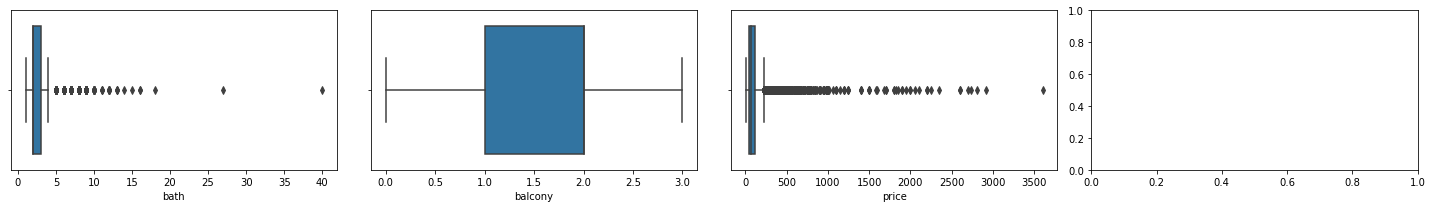

------------------------------

Categorical variables description: 

              count unique                   top   freq
area_type     13320      4  Super built-up  Area   8790
availability  13320     81         Ready To Move  10581
location      13319   1305            Whitefield    540
size          13304     31                 2 BHK   5199
society        7818   2688               GrrvaGr     80
total_sqft    13320   2117                  1200    843
------------------------------

Continous variables description: 

            count    mean     std   min    25%    50%     75%      max
bath     13247.00    2.69    1.34  1.00   2.00   2.00    3.00    40.00
balcony  12711.00    1.58    0.82  0.00   1.00   2.00    2.00     3.00
price    13320.00  112.57  148.97  8.00  50.00  72.00  120.00  3600.00


In [9]:
DataExp(HouseData)

### Data Processing

In [10]:
# Grouping Locations
Locationlessthan100 = HouseData.location.value_counts()[(HouseData.location.value_counts() <= 10)]
HouseData.location= HouseData.location.apply(lambda x: "others" if x in Locationlessthan100 else x)


In [11]:
# Noise Removal & TypeConversion

HouseData["Bedroom"] = pd.to_numeric(HouseData["size"].str.split(expand= True)[0])
HouseData["total_sqft"] = pd.to_numeric(HouseData.total_sqft.apply(lambda x: StrtoFloat(x)))


In [12]:
# Encoding Columns
HouseData = HouseData.join(pd.get_dummies(HouseData[HouseData.select_dtypes(include= "object").columns.difference(["availability","size", "area_type", "society"])], drop_first= True))

# Dropping insignificant columns
HouseData.drop(columns = ["location", "area_type", "availability","size", "society"], inplace= True)


In [13]:
# Missing Value Treatment

imp = KNNImputer(n_neighbors= 9)
HouseData = pd.DataFrame(data= imp.fit_transform(HouseData), columns= HouseData.columns)


In [14]:
# Outlier Treatment
HouseData[["total_sqft", "Bedroom", "bath", "price"]] = HouseData[["total_sqft", "Bedroom", "bath", "price"]].apply(lambda x: OutlierTreat(x))


In [15]:
# Creating Derived Column
# HouseData['price_per_sqft']=HouseData['price']*1000000/HouseData['total_sqft']

### Splitting data

In [16]:
X = HouseData.drop(columns = "price")
y = HouseData.price

In [17]:
# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape        ## Slight view to the data

((9324, 245), (3996, 245), (9324,), (3996,))

In [18]:
# Scaling Data
FeatStdscale = StandardScaler()
X_train[["total_sqft", "Bedroom", "bath", "balcony"]] = FeatStdscale.fit_transform(X_train[["total_sqft", "Bedroom", "bath", "balcony"]])

X_test[["total_sqft", "Bedroom", "bath", "balcony"]] = FeatStdscale.transform(X_test[["total_sqft", "Bedroom", "bath", "balcony"]])

#### Model Creation & Evaluation

In [19]:
result_df = BestAlgorithm(X_train, X_test,  y_train, y_test)

In [20]:
result_df

,Model,Best Parametres,Training Accuracy,Test Accuracy
0,Random Forest,"{'n_estimators': 90, 'min_samples_split': 9, '...",0.730761,0.744886


*Conclusion:*

*From the above table we can see that random fores gives us the best training and testing accuracy hence we will incorporate it to predict the new unseen data.*

In [21]:
# Storing Best Model
BestModel = RandomForestRegressor(**result_df.loc[result_df.Model == "Random Forest", "Best Parametres"].values[0], random_state= 42)
BestModel.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, max_features=0.5, min_samples_leaf=7,
                      min_samples_split=9, n_estimators=90, random_state=42)

In [22]:
r2_score(y_train, BestModel.predict(X_train))

0.7476727363025811